In [157]:
from sklearn.neural_network import MLPRegressor
import numpy as np
import pandas as pd
import data_extraction
import ARIMA
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [158]:
def ANN_train(X_train, y_train, hidden_layers, alpha=1e-5, random_state=1):
    '''
    INPUT:
    timeseries: TYPE: DataFrame. Contains column named 'residual'
    q: TYPE: Integer. Decides how many historical values to consider
    hidden_layers: TYPE: Tuple of integers. The number on the i'th position decides number of nodes in hidden layer i

    OUTPUT:
    Returns trained model: TYPE: MLPRegressor
    '''
    model = MLPRegressor(solver="lbfgs", 
                         alpha=alpha, 
                         hidden_layer_sizes=hidden_layers, 
                         random_state=random_state, 
                         max_iter=20000,
                         #learning_rate = "adaptive",
                         tol=1e-5) #default tolerance
    model.fit(X_train, y_train)
    return model

In [159]:
past_weeks = 50
hidden_layers = (30, 20, 10)
nRowsRead = None
grid_number = 1

df = pd.read_pickle('forecast1.pkl')

def to_datetime(string):
    return datetime.strptime(string, "%Y-%m-%d %H:%M:%S")


def to_string(date):
    return datetime.strftime(date, "%Y-%m-%d %H:%M:%S")


In [160]:
df['residuals'].size

12902

In [161]:
df['residuals'].values

array([ 0.11256685,  0.49642748,  0.57593696, ..., -1.36498322,
       -4.44076839, -2.67127598])

In [162]:
def data_ANN_train(past_weeks, df):
    # input values
    # past_vals is the number of past values of the residuals that the ANN will use
    residuals = df["residuals"]

    load_series_train = data_extraction.get_timeseries("train", nRowsRead, 'load', grid_number)
    load_series_test = data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number)
    
    X = []
    y = []
    
    for i in tqdm(range(len(residuals.values) - past_weeks*24*7)):
        X_el = residuals[i:i+24*7*past_weeks:24*7]
        X.append(X_el)
        y.append([residuals.iloc[i+past_weeks*24*7]])
    
    return X, y


In [163]:
X, y = data_ANN_train(past_weeks, df)


100%|██████████| 4502/4502 [00:00<00:00, 18242.55it/s]


In [164]:
X_train = X[:len(df)-len(data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number))]
y_train = y[:len(df)-len(data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number))]

In [165]:
len(X_train[0])

50

In [166]:
model = ANN_train(X_train, y_train, hidden_layers)

In [167]:
def data_ANN_test(past_weeks, df):
    residuals = df["residuals"]
    load_series_test = data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number)
    train_size = len(df)-len(data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number))
    X = []
    
    for i in tqdm(range(len(load_series_test))):
        X.append(residuals[train_size+i-past_weeks*24*7:train_size+i:24*7])
        
    
    return X
    

In [168]:
X_test = data_ANN_test(past_weeks, df)

100%|██████████| 4345/4345 [00:00<00:00, 42932.72it/s]


In [169]:
X_test[24*7*2+3].size

50

In [170]:
def ANN_pred(model, X_test, X, y):
    train_size = len(X)-len(data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number))
    X_test = X_test.copy()
    y_test = []
    for i in tqdm(range(len(X_test))):
        
        X_test_el = X_test[i].values
        
        val = model.predict(X_test_el.reshape(1,-1))

        y_test.append(val[0])
        """
        if i%24 == 23:
            if train_size +i > len(X)-1:
                continue
            model = ANN_train(X[:train_size+i+1], y[:train_size+i+1], hidden_layers)
        """ 
    return y_test



In [171]:
y_pred = ANN_pred(model, X_test,X,y)

100%|██████████| 4345/4345 [00:00<00:00, 7283.03it/s]


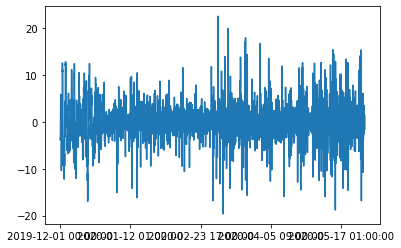

In [172]:
temp = pd.DataFrame(index = data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number).index)
temp['pred_residuals'] = y_pred
df = df.join(temp)
(df['residuals']-df['pred_residuals']).dropna().plot()

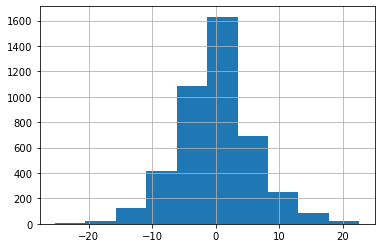

In [173]:
df["pred_residuals"].hist()

In [174]:
df = df.dropna()
df['Hybrid'] = df['ARIMA']+df['pred_residuals']
df['arima_sum_error'] = abs(df['grid-loss'] - df['ARIMA'])
df['hybrid_sum_error'] = abs(df['grid-loss'] - df['Hybrid'])

df['arima_cum'] = df['arima_sum_error'].cumsum()
df['hybrid_cum'] = df['hybrid_sum_error'].cumsum()
df['error_in_res'] = (df['residuals']-df['pred_residuals'])

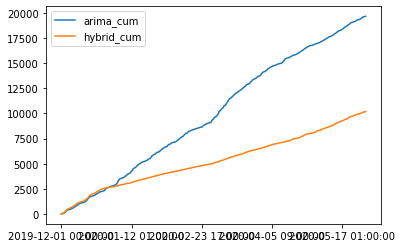

In [175]:
df[['arima_cum','hybrid_cum']].plot()


In [176]:
(df['arima_cum'].iloc[-1]-df['hybrid_cum'].iloc[-1])/df['arima_cum'].iloc[-1]

0.48236321871298954

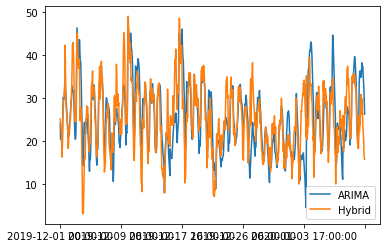

In [177]:
df[['ARIMA','Hybrid']].loc["2019-11-30 00:00:00":"2020-01-12 00:00:00"].plot()

In [178]:
diff = df['grid-loss']-df['Hybrid']
(diff**2).mean()

12.200968509050997

In [179]:
data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number)

2019-12-01 00:00:00    407.67600
2019-12-01 01:00:00    397.96600
2019-12-01 02:00:00    392.90400
2019-12-01 03:00:00    392.72600
2019-12-01 04:00:00    394.47800
                         ...    
2020-05-30 20:00:00    224.54790
2020-05-30 21:00:00    223.84220
2020-05-30 22:00:00    217.77730
2020-05-30 23:00:00    208.35270
2020-05-31 00:00:00    199.86566
Name: grid1-load, Length: 4345, dtype: float64

In [180]:
len(df['residuals'].dropna())-len(data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number))

-10

In [181]:
abs(df['error_in_res']).cumsum()

2019-12-01 00:00:00        3.637135
2019-12-01 01:00:00        7.459079
2019-12-01 02:00:00       11.053384
2019-12-01 03:00:00       13.216632
2019-12-01 04:00:00       14.338395
                           ...     
2020-05-30 19:00:00    10180.714176
2020-05-30 20:00:00    10180.787591
2020-05-30 21:00:00    10181.141374
2020-05-30 23:00:00    10182.750493
2020-05-31 00:00:00    10184.185196
Name: error_in_res, Length: 4335, dtype: float64